<a href="https://colab.research.google.com/github/ming80302/Innovator/blob/main/plot_mask_shp_rasterio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mask PRISM data with shapefile
!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy
!pip install rasterio
!pip install geopandas

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from importlib import reload
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine


### 1 functions defination

In [ ]:
# Reference:
# https://stackoverflow.com/questions/51398563/python-mask-netcdf-data-using-shapefile
def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(shapes, coords, latitude, longitude, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))


def add_shape_coord_from_data_array(xr_da, shp_gpd, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """
  
    # create a list of tuples (shapely.geometry, id)
    # this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords,
                               longitude='rlon', latitude='rlat')

    return xr_da


### 2) Innovation study area

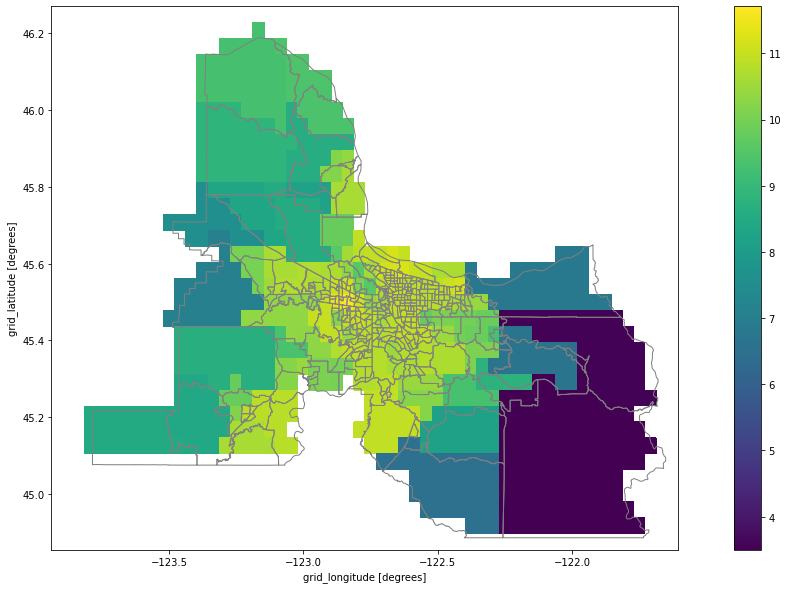

In [ ]:
flnm_shp = '/content/drive/MyDrive/data/ncar_study_area/ncar_oregon.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

## Grided dataset PRISM
ds = xr.open_dataset('/content/drive/MyDrive/data/PRISM_daily_tmax_2021.nc')
 
# Oregon INNOVATION proj
ds = ds.isel(time=0).isel(rlat=slice(88,122), rlon=slice(26, 82))
ds = ds.squeeze()

ds_da = add_shape_coord_from_data_array(ds, shp_gpd, "county")

shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]  
# convert list of tuple to list of list because I'm going to change it 
lists = [list(x) for x in shapes]

for nn in range(len(shapes)):
    county_da = ds_da.where(ds_da.county==nn, other=np.nan)
    
    # replace all dataArray values with county mean 
    lists[nn][1] = county_da.Tmax.mean(dim=('rlat', 'rlon')).values
    
# convert list of list to list of tuple in order to rasterize    
tuples = [tuple(x) for x in lists]
    
t_new = rasterize(tuples, ds_da.coords, longitude='rlon', latitude='rlat')
  
fig, ax = plt.subplots(figsize=(20, 10))

# plot shapeline 
shp_gpd.plot(ax=ax, edgecolor='grey', facecolor='none', zorder=1)
## make map plot first (zorder=0) and shapefile overlay (in front of map) it
t_new.plot(ax=ax, zorder=0)
plt.show()

### 3) Oregon counties

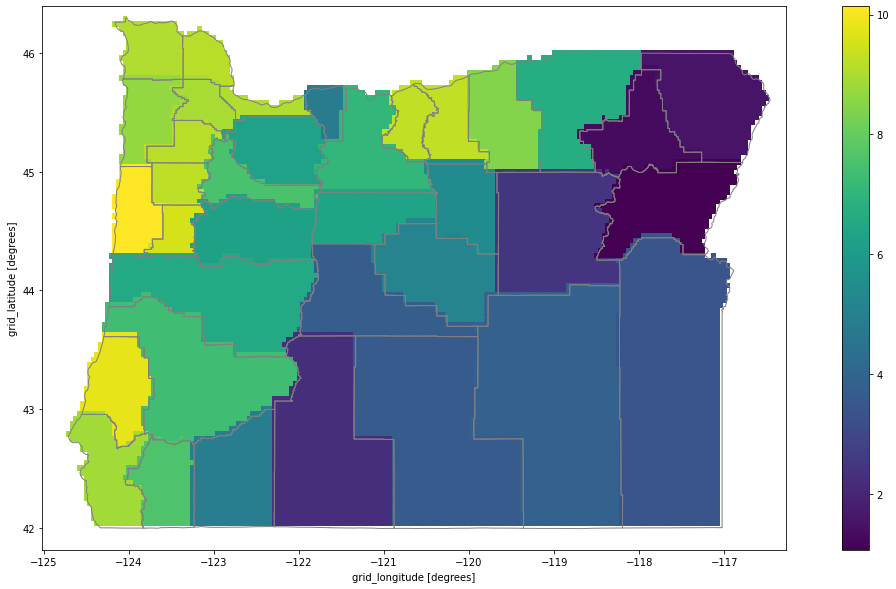

In [ ]:
flnm_shp = '/content/drive/MyDrive/data/COUNTIES_OREGON/counties.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')


## Grided dataset PRISM
ds = xr.open_dataset('/content/drive/MyDrive/data/PRISM_daily_tmax_2021.nc')
# Oregon i,j
ds = ds.isel(time=0).isel(rlat=slice(85,195), rlon=slice(0, 210))
ds = ds.squeeze()

ds_da = add_shape_coord_from_data_array(ds, shp_gpd, "county")

shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]  
# convert list of tuple to list of list
lists = [list(x) for x in shapes]

for nn in range(len(shapes)):
    county_da = ds_da.where(ds_da.county==nn, other=np.nan)
    
    # replace all dataArray values with county mean 
    #county_da.Tmax.loc[:,:] = county_da.Tmax.mean(dim=('rlat', 'rlon'))  
    lists[nn][1] = county_da.Tmax.mean(dim=('rlat', 'rlon')).values
    
# convert list of list to list of tuple in order to rasterize    
tuples = [tuple(x) for x in lists]
    
t_new = rasterize(tuples, ds_da.coords, longitude='rlon', latitude='rlat')
 
fig, ax = plt.subplots(figsize=(20, 10))
 
## make map plot first (zorder=0) and shapefile overlay (in front of map) it
t_new.plot(ax=ax, zorder=0)
shp_gpd.plot(ax=ax, edgecolor='grey', facecolor='none', zorder=1)
plt.show() 